In [83]:
!pip install -q xgboost
!pip install -q s3fs

In [84]:
# Load in our libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "colab" # to be replaced by "iframe" if working on JULIE

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
# import ensemble methods
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

In [85]:
data = pd.read_csv('/content/sample_data/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [86]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [87]:
data_sample = data.sample(10000)

In [88]:
# Basic stats
print("Number of rows : {}".format(data.shape[0]))
print("Number of columns : {}".format(data.shape[1]))
print()

print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Number of rows : 284580
Number of columns : 6

Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [89]:
numeric_features = ['total_pages_visited', 'age']
categorical_features = ['country', 'new_user','source' ] # Names of categorical columns in X_train/X_test
target_variable = 'converted'

In [90]:
# Separate target variable Y from features X
print("Separating labels from features...")

X = data.drop(target_variable, axis = 1)
Y = data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
X.head()

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :


,country,age,new_user,source,total_pages_visited
0,China,22,1,Direct,2
1,UK,21,1,Ads,3
2,Germany,20,0,Seo,14
3,US,23,1,Seo,3
4,US,28,1,Direct,3


In [91]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [92]:
#Preprocessings to be planned with scikit-learn
#Categorical variables : Store, Holiday_Flag
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))# missing values will be replaced by most frequent value
    ])
#Numerical variables : Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day, DayOfWeek
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values in Age will be replaced by columns' mean
    ('scaler', StandardScaler())
])

In [93]:
# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test) 
print('...Done.')
print(X_test[0:5,:])
print(X_test)

Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
178877   China   23         0  Direct                    2
215523   China   28         0     Ads                    2
73318    China   30         1     Seo                    7
58164       UK   37         1     Seo                    3
234640      US   31         1     Ads                    8
...Done.
[[-0.85939501 -0.91458053  0.          0.          0.          0.
   1.          0.        ]
 [-0.85939501 -0.30994956  0.          0.          0.          0.
   0.          0.        ]
 [ 0.63639894 -0.06809718  0.          0.          0.          1.
   0.          1.        ]
 [-0.56023622  0.77838618  0.          1.          0.          1.
   0.          1.        ]
 [ 0.93555773  0.05282902  0.          0.          1.          1.
   0.          0.        ]]

Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
269237   China   24         

In [94]:
# Perform grid search
print("Grid search...")
classifier = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best validation accuracy :  0.9852921638634488


In [95]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[9.99260081e-01 7.39918609e-04]
 [9.99260081e-01 7.39918609e-04]
 [9.99855908e-01 1.44092219e-04]
 ...
 [1.00000000e+00 0.00000000e+00]
 [9.26553672e-01 7.34463277e-02]
 [9.97963340e-01 2.03665988e-03]]



In [96]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[1.         0.        ]
 [0.99800029 0.00199971]
 [0.99800029 0.00199971]
 ...
 [0.99441341 0.00558659]
 [1.         0.        ]
 [0.99649696 0.00350304]]



In [97]:

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

f1-score on training set :  0.7729046145567066
f1-score on test set :  0.7437916414294368



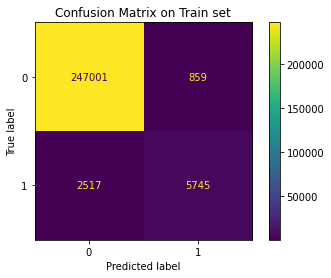

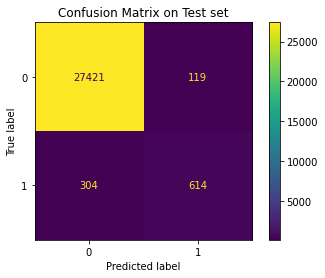

In [98]:
# Visualize confusion matrices
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [99]:
# Perform grid search
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [10],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
    'n_estimators': [10, 20, 40]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 10, n_jobs = -1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 40}
Best validation accuracy :  0.98599495607437


In [100]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[9.99275137e-01 7.24862646e-04]
 [9.98746489e-01 1.25351077e-03]
 [9.99687033e-01 3.12966932e-04]
 ...
 [9.93865894e-01 6.13410582e-03]
 [9.42899471e-01 5.71005290e-02]
 [9.97719122e-01 2.28087775e-03]]



In [101]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[0.89881366 0.10118634]
 [0.99555855 0.00444145]
 [0.99467927 0.00532073]
 ...
 [0.97303886 0.02696114]
 [0.99843636 0.00156364]
 [0.99745935 0.00254065]]



In [102]:
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

f1-score on training set :  0.7751241110962029
f1-score on test set :  0.7551266586248492



In [103]:
scores_df = pd.DataFrame(columns = ['model', 'f1_score', 'set'])

In [104]:
scores_df = scores_df.append({'model': 'random_forest', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'random_forest', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

,model,f1_score,set
0,random_forest,0.775124,train
1,random_forest,0.755127,test


In [105]:
print('Training Bagging of decision tree...')
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 5, min_samples_split = 4) # Same hyperparameters as best RF model
bagging = BaggingClassifier(base_estimator=decision_tree, n_estimators = 40)
bagging.fit(X_train, Y_train)



Training Bagging of decision tree...


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        min_samples_leaf=5,
                                                        min_samples_split=4),
                  n_estimators=40)

In [106]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = bagging.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = bagging.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[9.99582911e-01 4.17088635e-04]
 [9.99759081e-01 2.40918839e-04]
 [9.99128606e-01 8.71393576e-04]
 ...
 [9.99963778e-01 3.62222995e-05]
 [9.13940846e-01 8.60591544e-02]
 [9.97156609e-01 2.84339142e-03]]



In [107]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = bagging.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = bagging.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[9.60400523e-01 3.95994771e-02]
 [9.97187363e-01 2.81263730e-03]
 [9.98748951e-01 1.25104949e-03]
 ...
 [9.80895055e-01 1.91049451e-02]
 [9.99986118e-01 1.38819399e-05]
 [9.96196272e-01 3.80372795e-03]]



In [108]:
scores_df = scores_df.append({'model': 'bagging', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'bagging', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

,model,f1_score,set
0,random_forest,0.775124,train
1,random_forest,0.755127,test
2,bagging,0.778074,train
3,bagging,0.755102,test


In [109]:
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000)
adaboost_logreg = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0],
    'n_estimators': [40]
}
print(params)
grid_adaboost = GridSearchCV(adaboost_logreg, param_grid = params, cv = 10, verbose = 1,  n_jobs = -1) # cv : the number of folds to be used for CV
grid_adaboost.fit(X_train, Y_train)
print("...Done.")


Grid search...
{'base_estimator__C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0], 'n_estimators': [40]}
Fitting 10 folds for each of 8 candidates, totalling 80 fits
...Done.


In [110]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = grid_adaboost.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = grid_adaboost.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[0.56420357 0.43579643]
 [0.56552893 0.43447107]
 [0.55332649 0.44667351]
 ...
 [0.55473619 0.44526381]
 [0.51253694 0.48746306]
 [0.53409189 0.46590811]]



In [111]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = grid_adaboost.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = grid_adaboost.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[0.51643214 0.48356786]
 [0.53794858 0.46205142]
 [0.54023054 0.45976946]
 ...
 [0.52234336 0.47765664]
 [0.5598392  0.4401608 ]
 [0.5355272  0.4644728 ]]



In [112]:
scores_df = scores_df.append({'model': 'adaboost_logreg', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'adaboost_logreg', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

,model,f1_score,set
0,random_forest,0.775124,train
1,random_forest,0.755127,test
2,bagging,0.778074,train
3,bagging,0.755102,test
4,adaboost_logreg,0.764690,train
5,adaboost_logreg,0.757831,test


In [113]:
# Perform grid search
print("Grid search...")
gradientboost = GradientBoostingClassifier()

# Grid of values to be tested
params = {
    'max_depth': [10],
    'min_samples_leaf': [5],
    'min_samples_split': [4],
    'n_estimators': [40]
}
print(params)
gridsearch_gradient = GridSearchCV(gradientboost, param_grid = params, cv = 10, verbose = 1,  n_jobs = -1) # cv : the number of folds to be used for CV
gridsearch_gradient.fit(X_train, Y_train)

Grid search...
{'max_depth': [10], 'min_samples_leaf': [5], 'min_samples_split': [4], 'n_estimators': [40]}
Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10], 'min_samples_leaf': [5],
                         'min_samples_split': [4], 'n_estimators': [40]},
             verbose=1)

In [114]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch_gradient.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch_gradient.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[9.99153242e-01 8.46757825e-04]
 [9.99065439e-01 9.34560901e-04]
 [9.99124029e-01 8.75970934e-04]
 ...
 [9.99216009e-01 7.83990690e-04]
 [9.69565257e-01 3.04347428e-02]
 [9.94978569e-01 5.02143126e-03]]



In [115]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_gradient.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch_gradient.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[9.85640585e-01 1.43594152e-02]
 [9.96538482e-01 3.46151845e-03]
 [9.98497273e-01 1.50272713e-03]
 ...
 [9.74945263e-01 2.50547371e-02]
 [9.99293420e-01 7.06579909e-04]
 [9.94040896e-01 5.95910432e-03]]



In [116]:
scores_df = scores_df.append({'model': 'gradientboost', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'gradientboost', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

,model,f1_score,set
0,random_forest,0.775124,train
1,random_forest,0.755127,test
2,bagging,0.778074,train
3,bagging,0.755102,test
4,adaboost_logreg,0.764690,train
5,adaboost_logreg,0.757831,test
6,gradientboost,0.792709,train
7,gradientboost,0.750150,test


In [117]:
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [10],
    'min_child_weight': [1, 2, 4,5, 6, 8],
    'n_estimators': [40]
}
print(params)
gridsearch_xgboost = GridSearchCV(xgboost, param_grid = params, cv = 10, verbose = 1,  n_jobs = -1) # cv : the number of folds to be used for CV
gridsearch_xgboost.fit(X_train, Y_train)

Grid search...
{'max_depth': [10], 'min_child_weight': [1, 2, 4, 5, 6, 8], 'n_estimators': [40]}
Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10],
                         'min_child_weight': [1, 2, 4, 5, 6, 8],
                         'n_estimators': [40]},
             verbose=1)

In [118]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch_xgboost.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch_xgboost.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[0.9907869  0.00921307]
 [0.9907869  0.00921307]
 [0.989307   0.01069304]
 ...
 [0.9907869  0.00921307]
 [0.9127305  0.08726951]
 [0.9880653  0.01193469]]



In [119]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_xgboost.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch_xgboost.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[0.92210644 0.07789356]
 [0.98959243 0.01040757]
 [0.9899683  0.01003169]
 ...
 [0.9680563  0.03194365]
 [0.9909062  0.00909383]
 [0.9873003  0.01269974]]



In [120]:
scores_df = scores_df.append({'model': 'gridsearch_xgboost', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'gridsearch_xgboost', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

,model,f1_score,set
0,random_forest,0.775124,train
1,random_forest,0.755127,test
2,bagging,0.778074,train
3,bagging,0.755102,test
4,adaboost_logreg,0.764690,train
5,adaboost_logreg,0.757831,test
6,gradientboost,0.792709,train
7,gradientboost,0.750150,test
8,gridsearch_xgboost,0.772464,train
9,gridsearch_xgboost,0.756433,test


In [121]:
px.bar(scores_df, x = "model", y = 'f1_score', color = 'set', barmode = 'group', width = 900)

In [122]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

adaboost_logreg.fit(X,Y)

AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=1000))

Find feature importance on AdaBoostClassifier

In [123]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(X_train, Y_train) 
model.feature_importances_

array([0.58, 0.1 , 0.08, 0.12, 0.1 , 0.02, 0.  , 0.  ])

In [124]:
X_train

array([[-0.85939501, -0.91458053,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.85939501, -0.30994956,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63639894, -0.06809718,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-1.1585538 ,  0.05282902,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.23471652, -0.43087576,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.93555773,  0.65745999,  0.        , ...,  1.        ,
         0.        ,  1.        ]])

In [125]:
preprocessor.transformers_

[('num',
  Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]),
  ['total_pages_visited', 'age']),
 ('cat',
  Pipeline(steps=[('encoder', OneHotEncoder(drop='first'))]),
  ['country', 'new_user', 'source'])]

In [126]:
my_feature_list = []
my_feature_list.extend(preprocessor.transformers_[0][2])
my_feature_list.extend(preprocessor.transformers_[1][1].get_feature_names_out())

In [127]:
my_feature_list

['total_pages_visited',
 'age',
 'country_Germany',
 'country_UK',
 'country_US',
 'new_user_1',
 'source_Direct',
 'source_Seo']

In [128]:
feature_importance = pd.DataFrame(index = my_feature_list, data = model.feature_importances_)

In [129]:
sorted_feature_importance = feature_importance.sort_values(0)

In [130]:
# Plot coefficients
fig = px.bar(sorted_feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

# The content of the pages should be improved as it is the feature that is most revelant according to adaboost model